# Evaluation of NLG tasks - Reminders & Conversation generation.

## 1 - Defining the evaluation environment

### 1.1 - Imports & definitions

In [2]:
import os
import dotenv
import pandas as pd
from collections import Counter
import random

from src.constants import *
from src.openai_client import *
import numpy as np

open_ai_api_key = os.environ.get('OPENAI_API_KEY')
dotenv.load_dotenv()
import openai
from openai import OpenAI
from math import pi
import re
import matplotlib.pyplot as plt
from src.communication.messaging_service import SMSService
from src.communication.twilio_tool import NewTwilioConversationManager
from src.communication.reminder_manager import generate_personalised_reminder
from langchain_openai import ChatOpenAI
from src.prompts.prompts_templates import *
from src.data_manager.meal import get_recent_meals_string_for_user
from src.data_manager.nutritional_profiling import retrieve_nutritional_information, calculate_eating_consistency
from src.data_manager.reminder import get_previous_reminder_texts
from src.config.config import create_app
from src.utils.localization_utils import (
    get_localized_meal_type,
    get_localized_random_string,
    prompt_language_formatting
)
openai.api_key = os.environ.get('OPENAI_API_KEY')
eval_client = ChatOpenAI(temperature=1,model=GPT_4_O, api_key=open_ai_api_key)

C:\Users\dryha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Reminders - Prompt engineering - Using G-Eval

In [3]:
def sample_scores(prompt, n_samples = 20) :
    responses = []
    client = OpenAI()
    for i in range(n_samples) :
        response = client.chat.completions.create(
            model = GPT_4_O,
            messages = [{"role":"user", "content" : prompt}],
            temperature = 1.0,
            top_p = 1.0
        )
        text = response.choices[0].message.content.strip()
        responses.append(text)
        

    return responses

In [4]:
def parse_scores(responses):
    score_counts = Counter()
    pattern = re.compile(r"\b([1-5])\b")
    for r in responses:
        match = pattern.search(r)
        if match:
            score = int(match.group(1))
            score_counts[score] += 1

    total = sum(score_counts.values())
    if total == 0:
        return {i: 0 for i in range(1, 6)} 
    return {score: count / total for score, count in score_counts.items()}


def expected_score(probs):
    return sum(score * prob for score, prob in probs.items())


In [5]:
BASE_EVALUATION_PROMPT = """
You will be given a list of personalized reminders sent to a user of a food-tracking application. Your task is to rate this list of personalized reminders on specific evaluation metrics.

For each metric, you'll use a structured evaluation process and refer to a detailed scoring rubric with examples. This approach ensures consistent and objective assessment across different reminder sets.

Before rating, read through all reminders at least once to understand the full context. Keep the entire set visible while reviewing to ensure your assessment considers patterns across the complete sequence.
"""

EVALUATION_CRITERIA_ENGAGINGNESS = """
Engagingness (1–5) – This refers to how likely the reminders are to capture the user's attention and prompt them to take action.

Use the following step-by-step evaluation:
1. Read all reminders and identify specific engagement elements: motivational language, calls to action, curiosity triggers, or emotional resonance.
2. Assess the variety of engagement techniques used across the set.
3. Evaluate how engagement is maintained across the sequence (Do later reminders remain as engaging as earlier ones?).
4. Consider the balance between information delivery and motivation to act.
5. Note specific language that either enhances or diminishes engagement.

Scoring rubric:
1 - Flat, generic reminders with minimal attention-grabbing elements; purely instructional with minimal motivational content; unlikely to prompt action,
2 - Basic attempts at engagement but formulaic; limited variety in approach; engagement diminishes noticeably across the sequence,
3 - Moderately engaging with some effective techniques; maintains reasonable interest; includes some motivational elements alongside information,
4 - Consistently engaging with varied approaches; maintains interest throughout the sequence; effectively balances information with motivation,
5 - Exceptionally engaging with sophisticated techniques; compelling progression; creates a narrative that builds interest over time; highly likely to drive action.

Example of a "2" rating: "Hello ! It's time to log your lunch. Remember to track your progress today."
Example of a "4" rating: "Ready to celebrate your progress? A quick lunch log can keep that 7-day streak going! We noticed your fiber intake was a bit low, try to add some fiber-rich foods for today's lunch !"
"""

EVALUATION_CRITERIA_NATURALNESS = """
Naturalness (1–5) – This reflects how closely the reminders resemble authentic human communication rather than robotic or formulaic messages.

Use the following step-by-step evaluation:
1. Read each reminder aloud to assess flow and conversational quality.
2. Identify specific elements that affect naturalness: sentence structure variety, use of contractions, natural transitions, appropriate informality.
3. Note instances of awkward phrasing, overly technical language, unnatural word choices, or forced syntax.
4. Consider whether the reminders sound like something a supportive friend or coach would say.
5. Evaluate consistency of voice across the reminders.

Scoring rubric:
1 - Highly artificial language; robotic phrasing; awkward sentence structures; feels obviously computer-generated
2 - Somewhat stiff language; occasional natural elements but predominantly formal or mechanical; limited variety in expression
3 - Balanced mix of natural and artificial elements; sometimes sounds like a person, sometimes like a system
4 - Predominantly natural language; varied sentence structures; conversational tone; occasional minor mechanical elements
5 - Consistently natural language throughout; reads like authentic human communication; appropriate informal elements; varied and flowing

Example of a "2" rating: "Hello ! Do not forget to log in your meal today. It is important to include fibers in your meal. Good luck with your food journey."
Example of a "4" rating: "Looks like it's lunchtime ! When you get a chance, pop in what you had so we can keep your progress on track - you're doing great !"
"""

EVALUATION_CRITERIA_COHERENCE = """
Coherence (1–5) – This assesses how well the reminders relate to each other and form a consistent, sensible set that follows logical progression.

Use the following step-by-step evaluation:
1. Analyze the relationship between consecutive reminders, noting logical connections or contradictions.
2. Evaluate consistency in tone, purpose, and messaging strategy across the set.
3. Identify any thematic progression or narrative elements that connect the reminders.
4. Note any jarring transitions or contradictory messages that disrupt the flow.
5. Consider whether the reminders account for natural evolution in the user's diet or goals over time.

Scoring rubric:
1 - Disconnected messages with no apparent relationship; contradictory information; inconsistent voice or approach
2 - Minimal connections between reminders; occasional thematic consistency but frequent shifts in tone or purpose
3 - Moderately coherent with some logical progression; generally consistent voice with occasional discrepancies
4 - Strong relationships between reminders; clear thematic connections; consistent voice with natural evolution
5 - Exceptionally coherent set that builds progressively; thoughtful transitions; consistent voice that adapts appropriately to context changes

Example of a "2" rating: "Time to track your low-carb breakfast! ... Have you tried our new high-carb recipes? ... Remember to stick to your intermittent fasting schedule!"
Example of a "4" rating: "Morning check-in: How's your breakfast protein goal looking today? ... Nice work hitting your lunch targets! Your week's protein intake is trending up. ... Dinner planning time: You're just 15g away from your daily protein goal."
"""

EVALUATION_CRITERIA_PERSONALISATION = """
Personalisation (1–5) – This measures how tailored the reminders are to the specific user's context, preferences, habits, and goals.

Use the following step-by-step evaluation:
1. Identify specific references to the user's unique characteristics: dietary preferences, habits, goals, schedule, or past behaviors.
2. Note instances of contextual awareness (time of day, day of week, special occasions).
3. Assess references to the user's history or progress within the app.
4. Evaluate whether personalization feels authentic or superficial.
5. Count how many reminders contain substantive personalization versus generic content.

Scoring rubric:
1 - Generic messages with no user-specific information; could be sent to any user
2 - Minimal personalization limited to basic elements (name, time); predominantly generic content
3 - Moderate personalization with some specific references to user's patterns or preferences; mix of tailored and generic content
4 - Substantial personalization throughout; references to specific user behaviors, preferences and patterns; clearly tailored to individual
5 - Deeply personalized content that demonstrates comprehensive understanding of the user; anticipates needs based on established patterns; feels crafted specifically for this individual

Example of a "2" rating: "Good morning ! It's time to log your breakfast. Eating breakfast is important."
Example of a "4" rating: "Morning ! Today marks your 5th day keeping up with your fiber goal – that weekend planning is paying off! You're only 100g away from your daily protein goal, keep thriving !"
"""

EVALUATION_CRITERIA_DIVERSITY = """
Diversity (1–5) – This evaluates how varied the reminders feel in their expression, even when promoting persistent user needs (e.g Eating more carbohydrates, reducing sugar intake...)

Use the following step-by-step evaluation:
1. Analyze the structural patterns across reminders (sentence length, complexity, format, punctuation).
2. Identify variety in emotional tones (e.g., playful, empathetic, curious, motivational, informative).
3. Note the range of vocabulary and phrasing techniques used (metaphors, synonyms, varied expressions).
4. Assess the diversity of engagement approaches (questions, affirmations, nudges, observations, calls to action, etc.).
5. Consider whether the set avoids repetitive formulas or templates, even if the underlying intent is consistent.

Important: Reinforcing the same goal across reminders is acceptable (e.g., encouraging a habit or behavior over time). What matters is whether the way the reminders are delivered feels fresh and varied in form, tone, and language.

Scoring rubric:
1 - Highly repetitive in structure and language; near-identical phrasing; templated feel throughout
2 - Limited variation with repeated sentence formats and tones; minor tweaks only
3 - Moderate variety with some distinct expressions and tones; occasional repetition
4 - Good diversity across structure, tone, and phrasing; reminders stay engaging without obvious reuse
5 - Exceptional variety; each reminder feels distinct yet cohesive; broad vocabulary and sentence types; avoids formulaic patterns entirely

Example of a "2" rating: "Hi! Time to track your progress. ... Hey! Time to track your progress. ... Reminder: Don’t forget to track your progress. ... It’s time to track your progress now!"
Example of a "4" rating: "Still on track? Quick check-in time! ... Logging your effort today keeps your streak alive. ... Think you’ve improved since yesterday? Let’s find out. ... What’s one win you had today? Track it now!"
"""


SCORING_REQUEST = """
After completing your evaluation using the scoring rubric, please respond with only the number 1, 2, 3, 4, or 5 on a single line with no additional explanation or justification.
"""

In [6]:
def sample_scores(prompt, n_samples = 20) :
    responses = []
    client = OpenAI()
    for i in range(n_samples) :
        response = client.chat.completions.create(
            model = GPT_4_O,
            messages = [{"role":"user", "content" : prompt}],
            temperature = 1.0,
            top_p = 1.0
        )
        text = response.choices[0].message.content.strip()
        responses.append(text)
        

    return responses

def sample_scores_multiple_batches(prompt, n_samples_per_batch=20, n_batches=1):
    all_responses = []
    for batch in range(n_batches):
        print(f"Running batch {batch + 1}/{n_batches}")
        responses = sample_scores(prompt, n_samples=n_samples_per_batch)
        all_responses.extend(responses)
    return all_responses

In [7]:
def parse_scores(responses):
    score_counts = Counter()
    pattern = re.compile(r"\b([1-5])\b")
    for r in responses:
        match = pattern.search(r)
        if match:
            score = int(match.group(1))
            score_counts[score] += 1

    total = sum(score_counts.values())
    if total == 0:
        return {i: 0 for i in range(1, 6)} 
    return {score: count / total for score, count in score_counts.items()}


def expected_score(probs):
    return sum(score * prob for score, prob in probs.items())


In [8]:
def evaluate_reminders(reminders_list, base_prompt, criterion_prompt,output_shape_prompt):
    prompt = f"{base_prompt}\n{criterion_prompt}\nList of reminders (One reminder per line):\n{reminders_list}\n\n{output_shape_prompt}"
    responses = sample_scores_multiple_batches(prompt)
    #print("Raw responses:", responses)
    probs = parse_scores(responses)
    score = expected_score(probs)
    #print(f"Evaluation done.")
    return score, probs

In [9]:
def prompt_evaluation(reminders_dict,criteria,output_shape_prompt) :

    all_prompt_scores = {}

    for prompt_type, generated_reminders in reminders_dict.items() :
        #print(f"Currently treating {prompt_type} reminders:")
        all_prompt_scores[prompt_type] = {}
        
        for criterion_name, data in criteria.items() :
            #print(f"Evaluating {criterion_name}...")
            score, probs = evaluate_reminders(
                generated_reminders,
                BASE_EVALUATION_PROMPT,
                data["prompt"],
                SCORING_REQUEST
                )
            all_prompt_scores[prompt_type][data['label']] = (score,probs)

    return all_prompt_scores


In [17]:
import json
with open("generated_reminders.json", 'r') as f :
    generated_reminders = json.load(f)

criteria = {
"ENGAGINGNESS": {
    "prompt": EVALUATION_CRITERIA_ENGAGINGNESS,
    "label": "Engagingness"
},
"NATURALNESS": {
    "prompt": EVALUATION_CRITERIA_NATURALNESS,
    "label": "Naturalness"
},
"COHERENCE": {
    "prompt": EVALUATION_CRITERIA_COHERENCE,
    "label": "Coherence"
},
"PERSONALISATION": {
    "prompt": EVALUATION_CRITERIA_PERSONALISATION,
    "label": "Personalisation"
},
"DIVERSITY": {
    "prompt": EVALUATION_CRITERIA_DIVERSITY,
    "label": "Diversity"
}
}

all_prompt_scores = prompt_evaluation(generated_reminders,criteria,SCORING_REQUEST)


Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1
Running batch 1/1


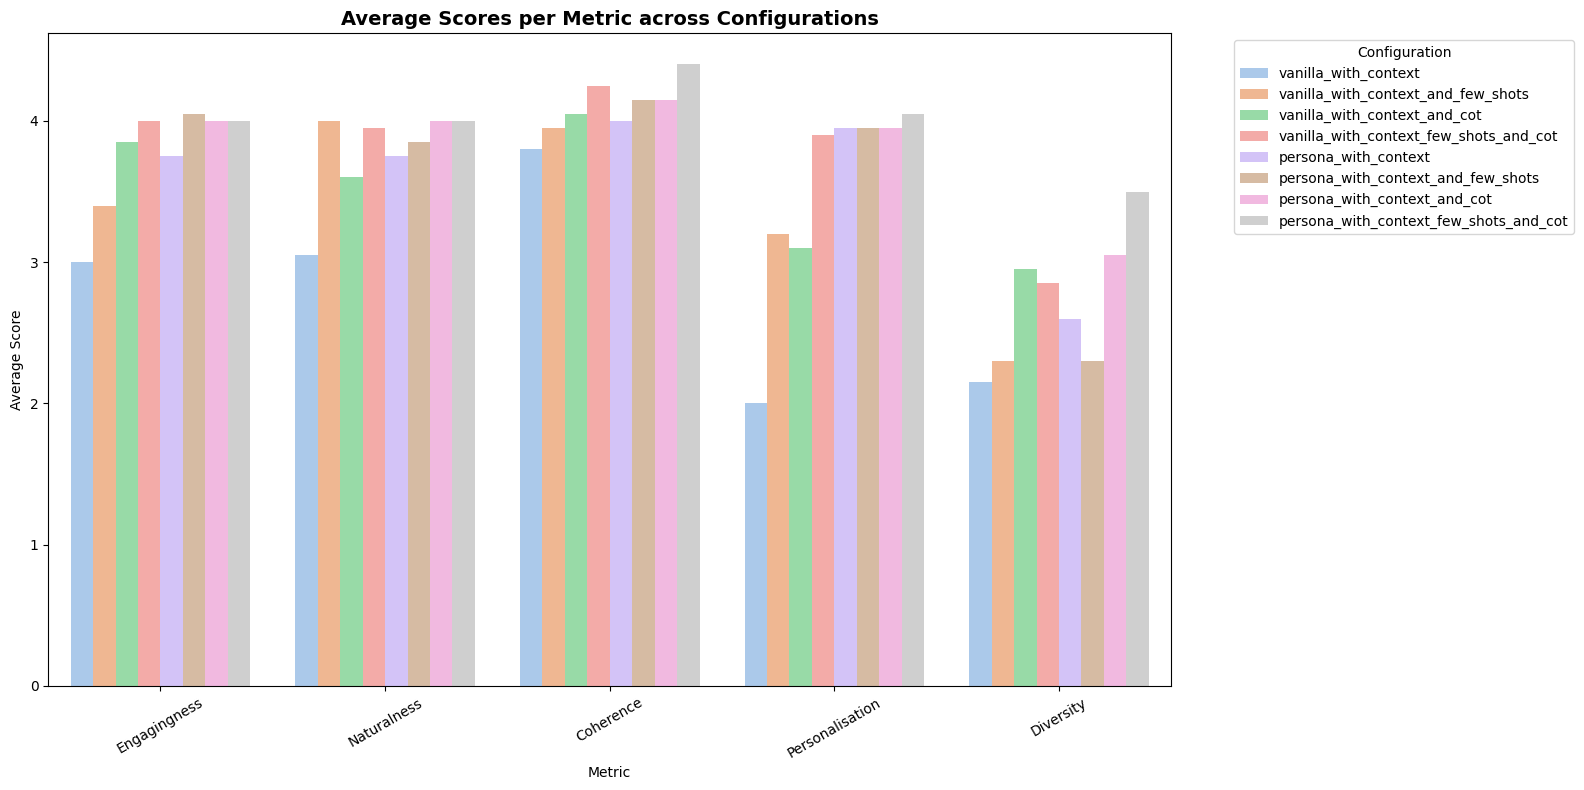

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build DataFrames (your part stays the same)
avg_scores = []
distribution_rows = []

for config, metrics in all_prompt_scores.items():
    for metric, (avg, dist) in metrics.items():
        avg_scores.append({'Configuration': config, 'Metric': metric, 'Average': avg})
        for score, pct in dist.items():
            distribution_rows.append({'Configuration': config, 'Metric': metric, 'Score': score, 'Percentage': pct})

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume avg_scores and distribution_rows were built as you did
df_avg = pd.DataFrame(avg_scores)
df_dist = pd.DataFrame(distribution_rows)

# === PLOT: Average Scores per Metric across Configurations ===
plt.figure(figsize=(16, 8))

# Use pastel palette, matching previous style
sns.set_palette("pastel")

# Barplot: x=Metric, y=Average, hue=Configuration
sns.barplot(data=df_avg, x='Metric', y='Average', hue='Configuration')

plt.title('Average Scores per Metric across Configurations', fontsize=14, fontweight='bold')
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(rotation=30)  # slight rotation for readability

# Move legend outside for clarity
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [23]:
df_avg

,Configuration,Metric,Average
0,vanilla_with_context,Engagingness,3.00
1,vanilla_with_context,Naturalness,3.05
2,vanilla_with_context,Coherence,3.80
3,vanilla_with_context,Personalisation,2.00
4,vanilla_with_context,Diversity,2.15
5,vanilla_with_context_and_few_shots,Engagingness,3.40
6,vanilla_with_context_and_few_shots,Naturalness,4.00
7,vanilla_with_context_and_few_shots,Coherence,3.95
8,vanilla_with_context_and_few_shots,Personalisation,3.20
9,vanilla_with_context_and_few_shots,Diversity,2.30


In [21]:
human_df = pd.read_csv("data/reminders_human_annotation.csv")
metrics = ['Engagingness', 'Naturalness', 'Coherence', 'Personalisation', 'Diversity']
technique_prefixes = [
    "Vanilla_FewShots",
    "Vanilla_CoT",
    "Vanilla_FewShots_CoT",
    "Persona_FewShots",
    "Persona_CoT",
    "Persona_FewShots_CoT"
]

new_columns = ['Timestamp']
for technique in technique_prefixes:
    for metric in metrics:
        new_columns.append(f"{technique}_{metric}")

human_df.columns = new_columns
human_df_melted = human_df.melt(id_vars=['Timestamp'], var_name='MetricFull', value_name='Score')
human_df_melted[['Configuration', 'Metric']] = human_df_melted['MetricFull'].str.extract(r'^(.*?)_(Engagingness|Naturalness|Coherence|Personalisation|Diversity)$')


grouped = human_df_melted.groupby(['Configuration', 'Metric'], sort=False)['Score'].mean().reset_index()
human_df_final = grouped.rename(columns={'Score': 'Average'})


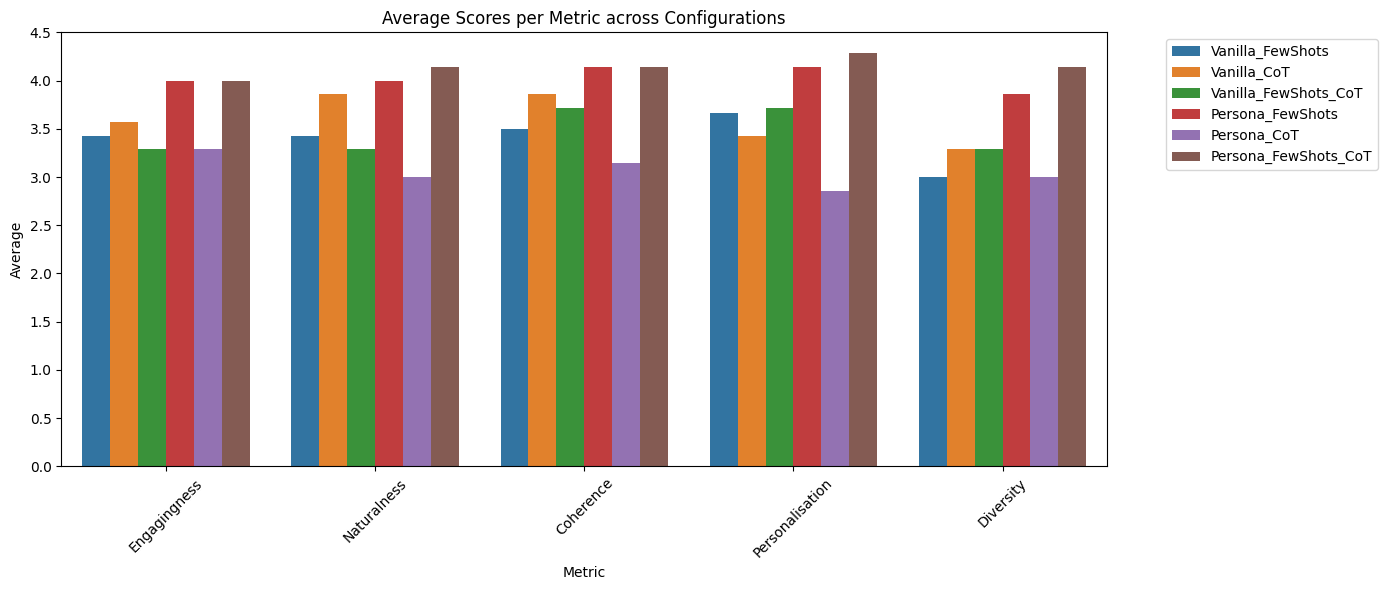

In [13]:
plt.figure(figsize=(14, 6))
sns.barplot(data=human_df_final, x='Metric', y='Average', hue='Configuration')
plt.xticks(rotation=45)
plt.title('Average Scores per Metric across Configurations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

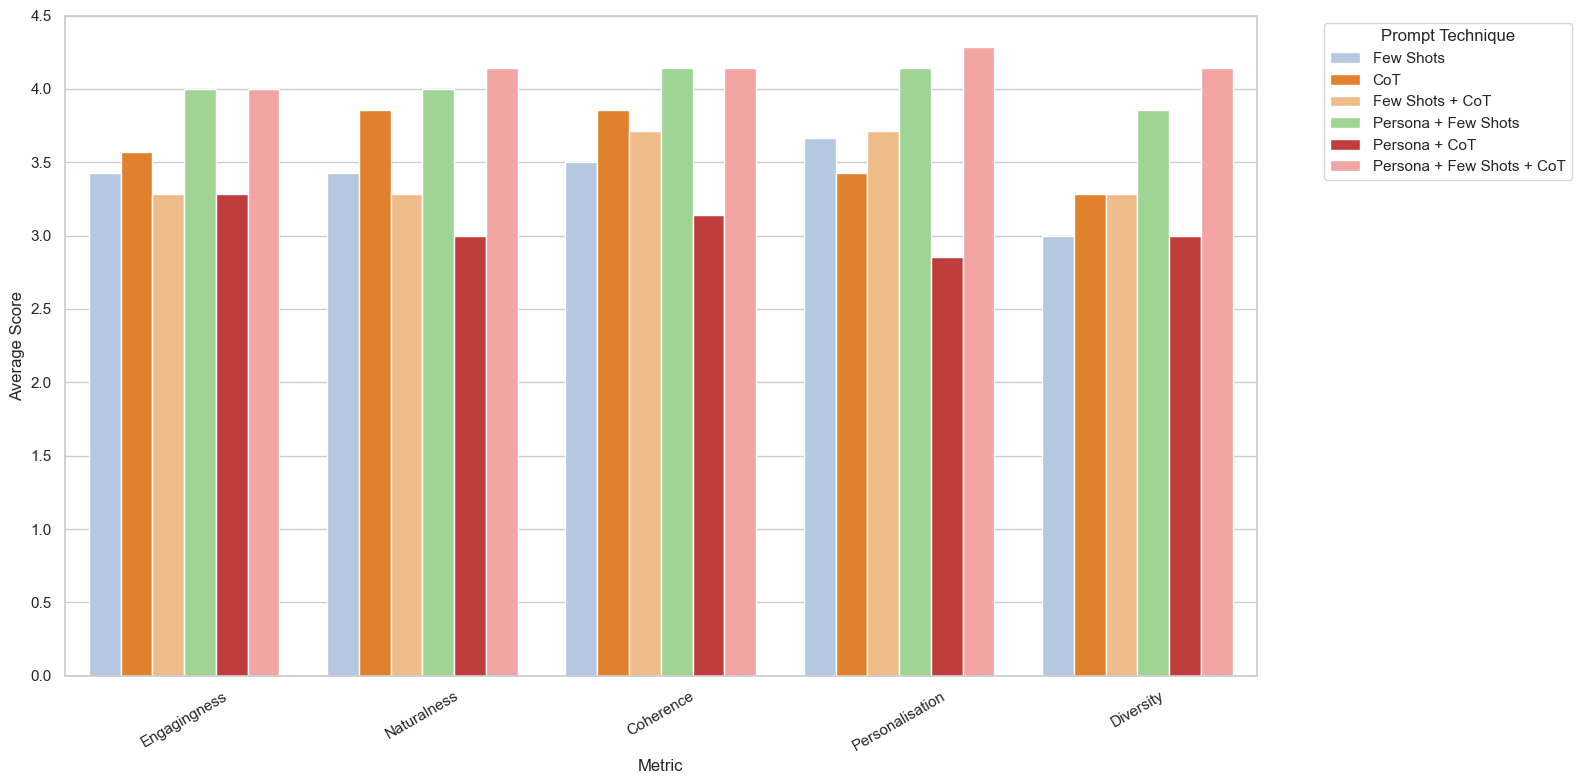

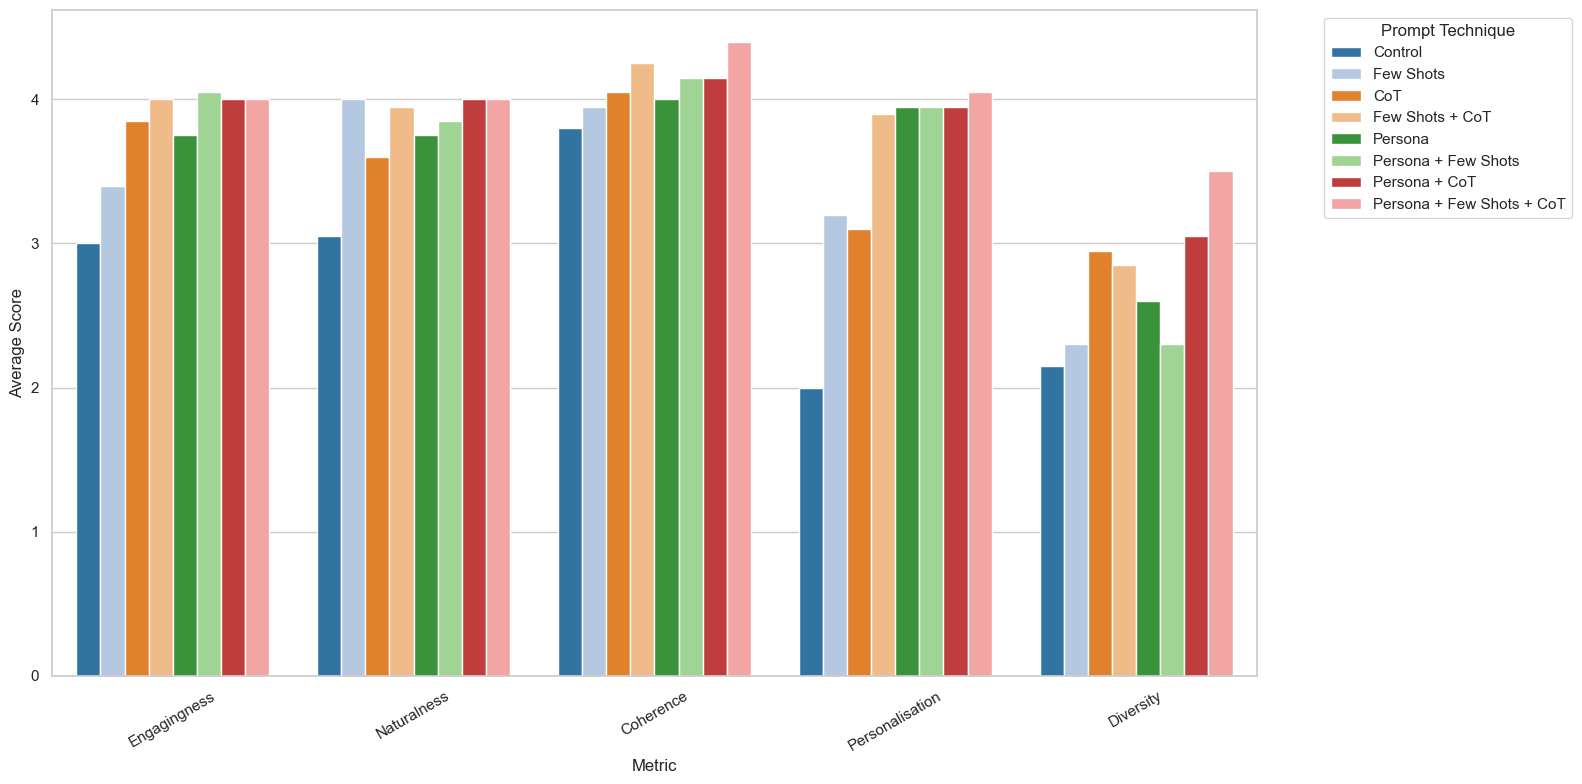

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Map to unified 'Technique' column ---

# Automatic data
df_avg_copy = df_avg.copy()
df_avg_copy['Technique'] = df_avg_copy['Configuration'].map({
    'vanilla_with_context': 'Control',
    'vanilla_with_context_and_few_shots': 'Few Shots',
    'vanilla_with_context_and_cot': 'CoT',
    'vanilla_with_context_few_shots_and_cot': 'Few Shots + CoT',
    'persona_with_context': 'Persona',
    'persona_with_context_and_few_shots': 'Persona + Few Shots',
    'persona_with_context_and_cot' : 'Persona + CoT',
    'persona_with_context_few_shots_and_cot': 'Persona + Few Shots + CoT'
})
df_avg_copy['Source'] = 'Automatic'

# Human data
human_df_copy = human_df_final.copy()
human_df_copy['Technique'] = human_df_copy['Configuration'].map({
    'Vanilla_FewShots': 'Few Shots',
    'Vanilla_CoT': 'CoT',
    'Vanilla_FewShots_CoT': 'Few Shots + CoT',
    'Persona_FewShots': 'Persona + Few Shots',
    'Persona_CoT': 'Persona + CoT',
    'Persona_FewShots_CoT': 'Persona + Few Shots + CoT'
})
human_df_copy['Source'] = 'Human'

# --- Step 2: Build unified color palette ---

all_techniques = pd.concat([df_avg_copy, human_df_copy], ignore_index=True)['Technique'].dropna().unique()
palette_colors = sns.color_palette('tab20', n_colors=len(all_techniques))
technique_palette = dict(zip(all_techniques, palette_colors))

sns.set(style='whitegrid')

# --- Step 3: Plot Human ratings (top plot) ---

plt.figure(figsize=(16, 8))
sns.barplot(
    data=human_df_copy,
    x='Metric',
    y='Average',
    hue='Technique',
    palette=technique_palette,
)
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(rotation=30)
plt.legend(title='Prompt Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Step 4: Plot Automatic ratings (bottom plot) ---

plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_avg_copy,
    x='Metric',
    y='Average',
    hue='Technique',
    palette=technique_palette,
)
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(rotation=30)
plt.legend(title='Prompt Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

